In [1]:
import django
import pandas as pd
import torch

django.setup()

from dbfcore.settings import TZ_UTC
from modelbackend.models import PredictionModel
from modelbackend.management.commands.runmodels import get_datasources_configured_with_env
from modelfrontend.visualization.expectedvalue import (
    get_forecast_expected_value,
    get_forecast_expected_value_eval_data,
    get_forecast_expected_value_errors,
    calculate_forecast_mae_from_plotly_fig_data,
    get_forecast_expected_value_mae,
    get_forecast_expected_value_outliers,
    plot_forecast_expected_value_errors,
)

torch.set_grad_enabled(False)

[2024-08-01 09:48:48,974] INFO  40553 140139384964928 datasets     PyTorch version 2.1.2 available.


#### Input variables setup

In [2]:
start = pd.Timestamp("2024-07-16", tzinfo=TZ_UTC)
end = pd.Timestamp("2024-07-31", tzinfo=TZ_UTC)
model = PredictionModel.objects.get(name="hotmetal_temp_C")
datasources = get_datasources_configured_with_env()
num_samples = 10**6
num_calc_times = 4

#### Forecast expected value training dataset (search for best aggregation function applied to decoded model predictions)

In [3]:
eval_data = get_forecast_expected_value_eval_data(model, start, end, None, num_calc_times)
eval_data = get_forecast_expected_value_errors(eval_data)
eval_data

/home/miro/python/DBF/dbfcore/dbfcore/utils.py:28: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(np.frombuffer(data, dtype=np.float32))


calc_time  expected_value_avg  expected_value_wavg  \
0    2024-07-15 20:25:00+00:00         1496.956883          1494.913475   
1    2024-07-15 21:25:00+00:00         1491.909410          1487.473646   
2    2024-07-15 22:25:00+00:00         1473.551830          1459.796422   
3    2024-07-15 23:25:00+00:00         1457.054523          1438.790995   
4    2024-07-15 20:47:00+00:00         1497.079697          1495.929210   
...                        ...                 ...                  ...   
1075 2024-07-30 21:05:00+00:00         1478.411597          1446.454800   
1076 2024-07-30 19:57:00+00:00         1540.614527          1540.380264   
1077 2024-07-30 20:57:00+00:00         1532.814401          1528.392010   
1078 2024-07-30 21:57:00+00:00         1512.019769          1496.899675   
1079 2024-07-30 22:57:00+00:00         1478.411597          1446.454800   

      expected_value_median  expected_value_wmedian  expected_value_truncavg  \
0               1496.905145             1493.759175              1496.860799   
1               1493.374258             1487.868058              1491.938737   
2               1481.866859             1457.754698              1474.356787   
3               1454.689918             1429.185507              1456.948995   
4               1497.158865             1496.080669              1497.040788   
...                     ...                     ...                      ...   
1075            1496.429382             1445.083571              1481.060616   
1076            1539.972735             1539.175427              1540.625852   
1077            1535.529504             1528.790953              1533.246015   
1078            1519.366160             1498.287649              1513.524964   
1079            1496.429382             1445.083571              1481.060616   

                 forecast_time  target  distance  abserror_avg  abserror_wavg  \
0    2024-07-16 00:25:00+00:00  1458.0       240     38.956883      36.913475   
1    2024-07-16 00:25:00+00:00  1458.0       180     33.909410      29.473646   
2    2024-07-16 00:25:00+00:00  1458.0       120     15.551830       1.796422   
3    2024-07-16 00:25:00+00:00  1458.0        60      0.945477      19.209005   
4    2024-07-16 00:47:00+00:00  1459.0       240     38.079697      36.929210   
...                        ...     ...       ...           ...            ...   
1075 2024-07-30 22:05:00+00:00  1472.0        60      6.411597      25.545200   
1076 2024-07-30 23:57:00+00:00  1453.0       240     87.614527      87.380264   
1077 2024-07-30 23:57:00+00:00  1453.0       180     79.814401      75.392010   
1078 2024-07-30 23:57:00+00:00  1453.0       120     59.019769      43.899675   
1079 2024-07-30 23:57:00+00:00  1453.0        60     25.411597       6.545200   

      abserror_median  abserror_wmedian  abserror_truncavg  
0           38.905145         35.759175          38.860799  
1           35.374258         29.868058          33.938737  
2           23.866859          0.245302          16.356787  
3            3.310082         28.814493           1.051005  
4           38.158865         37.080669          38.040788  
...               ...               ...                ...  
1075        24.429382         26.916429           9.060616  
1076        86.972735         86.175427          87.625852  
1077        82.529504         75.790953          80.246015  
1078        66.366160         45.287649          60.524964  
1079        43.429382          7.916429          28.060616  

[1080 rows x 14 columns]

#### MAE metrics used to select the best aggregation function for forecast expected value calculation

In [9]:
get_forecast_expected_value_mae(eval_data)

distance    mae_avg   mae_wavg  mae_median  mae_wmedian  mae_truncavg  \
0        60  36.357696  31.915637   37.525299    30.993269     36.499730   
1       120  42.737845  39.037755   43.449332    38.549729     42.846258   
2       180  48.861179  47.089568   49.493988    46.979521     48.908564   
3       240  53.136796  52.978109   53.127543    52.920750     53.132464   

   count  
0    270  
1    270  
2    270  
3    270

#### Forecast outliers 

In [6]:
def get_forecast_expected_value_outliers(
    eval_data: pd.DataFrame, agg_fn: str, distance: int, threshold: float, num_samples: int
) -> pd.DataFrame:
    errors = eval_data[(eval_data["distance"] == distance)]
    return errors.query(f"abserror_{agg_fn} > @threshold").sort_values(f"abserror_{agg_fn}", ascending=False)[
        :num_samples
    ]


get_forecast_expected_value_outliers(eval_data, "median", 60, 50, 10)

calc_time  expected_value_avg  expected_value_wavg  \
707 2024-07-28 05:04:00+00:00         1567.972205          1531.413117   
211 2024-07-20 16:06:00+00:00         1531.038167          1498.702068   
579 2024-07-26 04:23:00+00:00         1547.908742          1523.918220   
867 2024-07-29 16:31:00+00:00         1571.267960          1550.486327   
215 2024-07-20 16:33:00+00:00         1528.465056          1497.815385   
871 2024-07-29 17:38:00+00:00         1571.953073          1544.617959   
875 2024-07-29 17:56:00+00:00         1568.138850          1539.972294   
883 2024-07-29 19:39:00+00:00         1542.770429          1515.458860   
879 2024-07-29 19:19:00+00:00         1547.703647          1519.689858   
711 2024-07-28 05:27:00+00:00         1557.653533          1519.588623   

     expected_value_median  expected_value_wmedian  expected_value_truncavg  \
707            1592.527862             1511.955346              1568.190017   
211            1541.083187             1489.764822              1532.207085   
579            1560.171595             1525.485667              1547.623202   
867            1579.609580             1539.289570              1571.361730   
215            1534.889322             1476.059251              1528.657738   
871            1579.393852             1532.326904              1572.202186   
875            1572.515985             1540.476499              1568.538980   
883            1547.247058             1504.402801              1542.861157   
879            1548.179999             1513.272189              1548.049446   
711            1539.101614             1506.574711              1556.859891   

                forecast_time  target  distance  abserror_avg  abserror_wavg  \
707 2024-07-28 06:04:00+00:00  1422.0        60    145.972205     109.413117   
211 2024-07-20 17:06:00+00:00  1387.0        60    144.038167     111.702068   
579 2024-07-26 05:23:00+00:00  1412.0        60    135.908742     111.918220   
867 2024-07-29 17:31:00+00:00  1435.0        60    136.267960     115.486327   
215 2024-07-20 17:33:00+00:00  1403.0        60    125.465056      94.815385   
871 2024-07-29 18:38:00+00:00  1448.0        60    123.953073      96.617959   
875 2024-07-29 18:56:00+00:00  1446.0        60    122.138850      93.972294   
883 2024-07-29 20:39:00+00:00  1427.0        60    115.770429      88.458860   
879 2024-07-29 20:19:00+00:00  1429.0        60    118.703647      90.689858   
711 2024-07-28 06:27:00+00:00  1423.0        60    134.653533      96.588623   

     abserror_median  abserror_wmedian  abserror_truncavg  
707       170.527862         89.955346         146.190017  
211       154.083187        102.764822         145.207085  
579       148.171595        113.485667         135.623202  
867       144.609580        104.289570         136.361730  
215       131.889322         73.059251         125.657738  
871       131.393852         84.326904         124.202186  
875       126.515985         94.476499         122.538980  
883       120.247058         77.402801         115.861157  
879       119.179999         84.272189         119.049446  
711       116.101614         83.574711         133.859891

#### Forecast errors plots

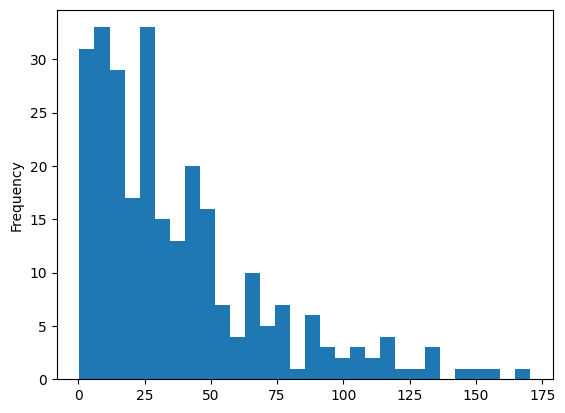

In [6]:

def plot_forecast_expected_value_errors(eval_data: pd.DataFrame, agg_fn: str, distance: int) -> pd.DataFrame:
    errors = eval_data[(eval_data["distance"] == distance)]
    errors[f"abserror_{agg_fn}"].plot.hist(bins=30)
    errors[["forecast_time", f"abserror_{agg_fn}"]].set_index("forecast_time").plot(figsize=(15, 4))


plot_forecast_expected_value_errors(eval_data, "median", 60)

#### Forecast expected value for specific `calc_time`

In [8]:
get_forecast_expected_value(model, start)

calc_time             forecast_time  expected_value
0   2024-07-16 00:00:00+00:00 2024-07-16 00:01:00+00:00     1452.138426
1   2024-07-16 00:00:00+00:00 2024-07-16 00:02:00+00:00     1451.164844
2   2024-07-16 00:00:00+00:00 2024-07-16 00:03:00+00:00     1450.202816
3   2024-07-16 00:00:00+00:00 2024-07-16 00:04:00+00:00     1449.264301
4   2024-07-16 00:00:00+00:00 2024-07-16 00:05:00+00:00     1448.352785
..                        ...                       ...             ...
235 2024-07-16 00:00:00+00:00 2024-07-16 03:56:00+00:00     1446.186507
236 2024-07-16 00:00:00+00:00 2024-07-16 03:57:00+00:00     1445.849534
237 2024-07-16 00:00:00+00:00 2024-07-16 03:58:00+00:00     1445.489134
238 2024-07-16 00:00:00+00:00 2024-07-16 03:59:00+00:00     1445.145469
239 2024-07-16 00:00:00+00:00 2024-07-16 04:00:00+00:00     1444.837795

[240 rows x 3 columns]